# Simple NN with Keras

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
np.random.seed(1671) # for reproducibility

# network and training
NB_CLASSES = 10 # number of outputs = number of digits
VALIDATION_SPLIT=0.2 # how much TRAIN is reserved for VALIDATION

# data: shuffled and split between train and test sets
#
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
RESHAPED = 784
#
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize
#
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# 10 outputs
# final stage is softmax

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(RESHAPED,)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

Using TensorFlow backend.


60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [3]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001, 
                               patience=0, verbose=0, mode='auto')

In [4]:
from keras_tqdm import TQDMNotebookCallback
history = model.fit(X_train, Y_train,
                    batch_size=128, epochs=100,
                    verbose=0, validation_split=VALIDATION_SPLIT,
                    callbacks=[TQDMNotebookCallback(show_inner=False), early_stopping])

Widget Javascript not detected.  It may not be installed or enabled properly.


In [5]:
score = model.evaluate(X_test, Y_test)
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

 8064/10000 [=======================>......] - ETA: 0s
Test loss: 0.10940781109
Test accuracy: 0.9668


In [6]:
# calculate predictions
score = model.predict_proba(X_test)
score

 9728/10000 [============================>.] - ETA: 0s

array([[  4.47188677e-06,   9.58873670e-07,   1.89468847e-04, ...,
          9.97663617e-01,   8.93157176e-06,   1.40800621e-04],
       [  3.31590505e-04,   3.10127449e-04,   9.95706499e-01, ...,
          2.59319766e-09,   7.66564743e-04,   1.30650415e-08],
       [  5.57889107e-05,   9.88898695e-01,   2.29561888e-03, ...,
          5.12155145e-03,   1.25670107e-03,   8.54217287e-05],
       ..., 
       [  1.26058195e-08,   2.88390538e-08,   2.37817858e-07, ...,
          3.49801740e-05,   1.20257377e-04,   1.08159776e-03],
       [  1.15627790e-05,   8.78242863e-05,   3.08895392e-06, ...,
          2.07858943e-06,   1.60403980e-03,   3.76937663e-07],
       [  1.69513823e-05,   1.57885029e-08,   1.66417944e-04, ...,
          3.03551637e-08,   7.62055288e-06,   2.39754741e-08]], dtype=float32)

# skip-gram word2vec model

In [7]:
from keras.layers import Merge
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
import keras.backend as K

vocab_size = 5000
embed_size = 300

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size,)))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                            embeddings_initializer="glorot_uniform",
                            input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
model.add(Merge([word_model, context_model], mode="dot", dot_axes=0))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

model.compile(loss="mean_squared_error", optimizer="adam")

merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [8]:
from keras.preprocessing.text import *
from keras.preprocessing.sequence import skipgrams

text = "I love green eggs and ham ."

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

wids = [word2id[w] for w in text_to_word_sequence(text)]
pairs, labels = skipgrams(wids, len(word2id))
print(len(pairs), len(labels))
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        id2word[pairs[i][0]], pairs[i][0], 
        id2word[pairs[i][1]], pairs[i][1],
        labels[i]))

56 56
(love (2), ham (6)) -> 1
(ham (6), love (2)) -> 1
(ham (6), green (3)) -> 0
(and (5), and (5)) -> 0
(eggs (4), ham (6)) -> 1
(love (2), green (3)) -> 1
(and (5), eggs (4)) -> 0
(green (3), i (1)) -> 1
(eggs (4), love (2)) -> 1
(green (3), love (2)) -> 1


In [9]:
len(word2id)

6

In [10]:
wids

[1, 2, 3, 4, 5, 6]

In [11]:
word2id

{'and': 5, 'eggs': 4, 'green': 3, 'ham': 6, 'i': 1, 'love': 2}

In [12]:
pairs, labels = skipgrams([1,2,3,4,5,6,7,8,9,10], 10, shuffle=False)

In [13]:
len(pairs)

120

In [14]:
for i in range(100):
    print(pairs[i], labels[i])

[1, 2] 1
[1, 3] 1
[1, 4] 1
[1, 5] 1
[2, 1] 1
[2, 3] 1
[2, 4] 1
[2, 5] 1
[2, 6] 1
[3, 1] 1
[3, 2] 1
[3, 4] 1
[3, 5] 1
[3, 6] 1
[3, 7] 1
[4, 1] 1
[4, 2] 1
[4, 3] 1
[4, 5] 1
[4, 6] 1
[4, 7] 1
[4, 8] 1
[5, 1] 1
[5, 2] 1
[5, 3] 1
[5, 4] 1
[5, 6] 1
[5, 7] 1
[5, 8] 1
[5, 9] 1
[6, 2] 1
[6, 3] 1
[6, 4] 1
[6, 5] 1
[6, 7] 1
[6, 8] 1
[6, 9] 1
[6, 10] 1
[7, 3] 1
[7, 4] 1
[7, 5] 1
[7, 6] 1
[7, 8] 1
[7, 9] 1
[7, 10] 1
[8, 4] 1
[8, 5] 1
[8, 6] 1
[8, 7] 1
[8, 9] 1
[8, 10] 1
[9, 5] 1
[9, 6] 1
[9, 7] 1
[9, 8] 1
[9, 10] 1
[10, 6] 1
[10, 7] 1
[10, 8] 1
[10, 9] 1
[3, 7] 0
[10, 6] 0
[2, 9] 0
[9, 9] 0
[6, 9] 0
[5, 4] 0
[10, 6] 0
[2, 7] 0
[3, 3] 0
[3, 2] 0
[10, 5] 0
[8, 8] 0
[5, 7] 0
[3, 9] 0
[8, 2] 0
[4, 1] 0
[9, 9] 0
[3, 4] 0
[6, 9] 0
[6, 2] 0
[5, 5] 0
[4, 8] 0
[4, 8] 0
[7, 3] 0
[7, 2] 0
[7, 8] 0
[4, 4] 0
[1, 7] 0
[9, 3] 0
[1, 8] 0
[8, 9] 0
[9, 5] 0
[8, 3] 0
[5, 1] 0
[2, 7] 0
[5, 9] 0
[6, 5] 0
[6, 7] 0
[7, 5] 0
[1, 2] 0


`negative_samples`는 positive samples 배수만큼 워드를 랜덤 샘플링하여 negative로 정의한다. 문장이 짧을때는 context words가 negative인 경우가 발생하는데 a little bit buggy로 보인다. context words인 경우에는 skip 하도록 패치가 필요할듯. 그러나 문장이 길 경우에는 context words가 negative로 정의될 가능성은 매우 낮다.

word2vec은 예측 모델이고 GloVe는 카운트 기반 모델이다.

# word2vec basic with Tensorflow

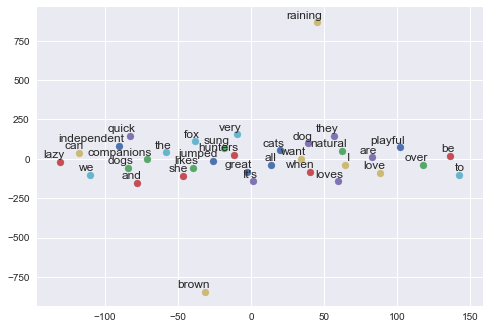

In [15]:
# Inspired by https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
import collections
import tensorflow as tf

from six.moves import xrange 

# Configuration
batch_size = 20
# Dimension of the embedding vector.
embedding_size = 10
num_sampled = 15    # Number of negative examples to sample.

# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

# sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
# print ("Word count", count[:5])

# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

# Make indexed word data
data = [dic[word] for word in words]
# print('Sample data', data[:10], [rdic[t] for t in data[:10]])

# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
# print('Context pairs', cbow_pairs[:10])

# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
# print('skip-gram pairs', skip_gram_pairs[:5])

def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
# print ('Batches (x, y)', generate_batch(3))

# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.global_variables_initializer().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()

from sklearn.manifold import TSNE

# 기존 샘플은 그래프로 표현하기 위해 embedding_size=2로 설정하여 임베딩을 의미있게 표현하기 힘들었다.
# 여기서는 충분한 차원으로 임베딩하고 t-SNE로 차원축소하여 표현한다.
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000)
plot_only = 500
low_dim_embs = tsne.fit_transform(trained_embeddings[:plot_only, :])
labels = rdic[:plot_only]

assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()